### Step 1: Import the libraries

In [1]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as BS
import requests
import pandas as pd
import warnings

from pathlib import Path 

import numpy as np 
import pandas as pd 
import re

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression 
from pandas.plotting import scatter_matrix, parallel_coordinates

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings("ignore")

no display found. Using non-interactive Agg backend


### Step 2: Get the data from Jobsdb website

In [3]:
url = "https://hk.jobsdb.com/business-analyst-jobs"
headers = {'User_Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
response = requests.get(url, headers=headers)
soup = BS(response.text, 'html.parser')

div_tags = soup.find_all("div")

# Create an empty list to store the extracted data
jobs_data = []

# Define the allowed data-automation values
data_automation_values = [
    "jobTitle",
    "jobCompany",
    "jobLocation",
    "jobClassification",
    "jobSalary",
    "jobSubClassification"
]

# Extract text for specific data-automation values
for div_tag in div_tags:
    a_tags = div_tag.find_all(['a', 'span'])
    for a_tag in a_tags:
        data_automation = a_tag.get("data-automation")
    
        if data_automation in data_automation_values:
            text = a_tag.get_text().strip()
            jobs_data.append(f"{data_automation}: {text}")


In [4]:
recs = []
current_rec = {}
for i in jobs_data:
    key, value = i.split(': ', 1)  # Split each item into key and value
    if key in current_rec:
        if isinstance(current_rec[key], list):
            current_rec[key].append(value)
        else:
            current_rec[key] = [current_rec[key], value]
    else:
        current_rec[key] = value
    if key == 'jobClassification':
        for key, value in current_rec.items():
            if isinstance(value, list):
                current_rec[key] = tuple(value)
        recs.append(current_rec)
        current_rec = {}
df = pd.DataFrame(recs)
df_unique = df.drop_duplicates()

In [5]:
df_unique.dropna(subset=["jobTitle"], inplace=True)

In [6]:
df_unique.to_csv('final.csv', index=False)

In [7]:
df_unique

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
0,"IT Analyst, Business Applications (1 year Cont...",Royal Shalom Group Holdings Company Limited,Sha Tin District,"$20,000 – $25,000 per month",Business/Systems Analysts,(Information & Communication Technology)
1,Business Analyst at ACT Solutions Limited (Fre...,Jobsdb - SmartHire,Southern District,NaN,Engineering - Software,(Information & Communication Technology)
2,"AM to AVP, Business Project Management",China Construction Bank (Asia) Corporation Lim...,"(Kowloon Bay, Kwun Tong District)",NaN,Banking - Retail/Branch,(Banking & Financial Services)
3,Business System Analyst,TEKsystems,Central and Western District,"$55,000 – $65,000 per month",Business/Systems Analysts,(Information & Communication Technology)
4,Senior Business Analyst,Gientech Technology (Hong Kong) Limited,"(Wan Chai, Wan Chai District)",NaN,Business/Systems Analysts,(Information & Communication Technology)
...,...,...,...,...,...,...
901,"(Business Analyst / Consultant up to 40k, Busi...","(Pathsight Limited, Pathsight Limited, Pathsig...",Hong Kong,NaN,Engineering - Software,(Information & Communication Technology)
914,"(Business Analyst, Client Servicing - Private ...","(PFCC Group Limited, PFCC Group Limited, PFCC ...","(Tsim Sha Tsui, Yau Tsim Mong District)","$50,000 – $60,000 per month",Analysis & Reporting,(Banking & Financial Services)
927,"(Officer, Business Process Analytics (Supply C...","(Maxim's Caterers Limited, Maxim's Caterers Li...","(Lai Chi Kok, Sham Shui Po District)",NaN,Business/Systems Analysts,(Information & Communication Technology)
940,"(Business Analyst, Business Analyst, Business ...","(Ambition, Ambition, Ambition, Ambition, Ambit...",Central and Western District,$30k - $40k p.m.,Analysis & Reporting,(Accounting)


### Step 3: Load the downloaded data from local

In [8]:
jobs_df = pd.read_csv('final.csv')

### Step 4: Exploratory Data Analysis

In [9]:
jobs_df.head()

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
0,"IT Analyst, Business Applications (1 year Cont...",Royal Shalom Group Holdings Company Limited,Sha Tin District,"$20,000 – $25,000 per month",Business/Systems Analysts,(Information & Communication Technology)
1,Business Analyst at ACT Solutions Limited (Fre...,Jobsdb - SmartHire,Southern District,NaN,Engineering - Software,(Information & Communication Technology)
2,"AM to AVP, Business Project Management",China Construction Bank (Asia) Corporation Lim...,"('Kowloon Bay', 'Kwun Tong District')",NaN,Banking - Retail/Branch,(Banking & Financial Services)
3,Business System Analyst,TEKsystems,Central and Western District,"$55,000 – $65,000 per month",Business/Systems Analysts,(Information & Communication Technology)
4,Senior Business Analyst,Gientech Technology (Hong Kong) Limited,"('Wan Chai', 'Wan Chai District')",NaN,Business/Systems Analysts,(Information & Communication Technology)


In [10]:
jobs_df.describe()

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
count,64,64,64,16,64,64
unique,60,54,19,8,14,7
top,"('Business Analyst', 'Business Analyst', 'Busi...",KPMG,Central and Western District,"$20,000 – $25,000 per month",Business/Systems Analysts,(Information & Communication Technology)
freq,2,2,8,2,20,34


In [11]:
jobs_df.columns

Index(['jobTitle', 'jobCompany', 'jobLocation', 'jobSalary',
       'jobSubClassification', 'jobClassification'],
      dtype='object')

In [12]:
jobs_df['jobTitle'] = jobs_df['jobTitle'].str.split(',').str[0]
jobs_df['jobCompany'] = jobs_df['jobCompany'].str.split(',').str[0]
jobs_df.head()

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
0,IT Analyst,Royal Shalom Group Holdings Company Limited,Sha Tin District,"$20,000 – $25,000 per month",Business/Systems Analysts,(Information & Communication Technology)
1,Business Analyst at ACT Solutions Limited (Fre...,Jobsdb - SmartHire,Southern District,NaN,Engineering - Software,(Information & Communication Technology)
2,AM to AVP,China Construction Bank (Asia) Corporation Lim...,"('Kowloon Bay', 'Kwun Tong District')",NaN,Banking - Retail/Branch,(Banking & Financial Services)
3,Business System Analyst,TEKsystems,Central and Western District,"$55,000 – $65,000 per month",Business/Systems Analysts,(Information & Communication Technology)
4,Senior Business Analyst,Gientech Technology (Hong Kong) Limited,"('Wan Chai', 'Wan Chai District')",NaN,Business/Systems Analysts,(Information & Communication Technology)


In [13]:
print('Number of rows with valid jobSalary values before: ', 
      jobs_df['jobSalary'].count()) 
missingRows = jobs_df.sample(10).index
jobs_df.loc[missingRows, 'jobSalary'] = np.nan
print('Number of rows with valid jobSalary values after setting to NAN: ', 
      jobs_df['jobSalary'].count()) 
jobs_df['jobSalary'].count()

Number of rows with valid jobSalary values before:  16
Number of rows with valid jobSalary values after setting to NAN:  9


9

In [14]:
reduced_df = jobs_df.dropna()
print('Number of rows after removing rows with missing values: ', len(reduced_df))

Number of rows after removing rows with missing values:  9


In [15]:
# Finding the most frequent value in 'jobSalary' column
most_frequent_salary = jobs_df['jobSalary'].mode()[0]

# Filling missing values with the most frequent value
jobs_df['jobSalary'] = jobs_df['jobSalary'].fillna(value=most_frequent_salary)

print('Number of rows with valid salary values after filling NA values: ',
      jobs_df['jobSalary'].count())


Number of rows with valid salary values after filling NA values:  64


In [16]:
jobs_df.dropna(subset=['jobCompany'], inplace=True)

In [17]:
jobs_df.describe()

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
count,64,64,64,64,64,64
unique,55,54,19,6,14,7
top,Business Analyst,KPMG,Central and Western District,"$20,000 – $25,000 per month",Business/Systems Analysts,(Information & Communication Technology)
freq,5,2,8,57,20,34


In [18]:
jobs_df['jobClassification'] = jobs_df['jobClassification'].str.replace(r'[()]', '', regex=True)
jobs_df['jobTitle'] = jobs_df['jobTitle'].str.replace(r'[()]', '', regex=True)
jobs_df['jobCompany'] = jobs_df['jobCompany'].str.replace(r'[()]', '', regex=True)
jobs_df['jobLocation'] = jobs_df['jobLocation'].str.replace(r'[()]', '', regex=True)
jobs_df['jobCompany'] = jobs_df['jobCompany'].str.replace("'", '')
jobs_df['jobTitle'] = jobs_df['jobTitle'].str.replace("'", '')
jobs_df['jobLocation'] = jobs_df['jobLocation'].str.replace("'", '')

In [19]:
jobs_df.head()

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
0,IT Analyst,Royal Shalom Group Holdings Company Limited,Sha Tin District,"$20,000 – $25,000 per month",Business/Systems Analysts,Information & Communication Technology
1,Business Analyst at ACT Solutions Limited Fres...,Jobsdb - SmartHire,Southern District,"$20,000 – $25,000 per month",Engineering - Software,Information & Communication Technology
2,AM to AVP,China Construction Bank Asia Corporation Limited,"Kowloon Bay, Kwun Tong District","$20,000 – $25,000 per month",Banking - Retail/Branch,Banking & Financial Services
3,Business System Analyst,TEKsystems,Central and Western District,"$55,000 – $65,000 per month",Business/Systems Analysts,Information & Communication Technology
4,Senior Business Analyst,Gientech Technology Hong Kong Limited,"Wan Chai, Wan Chai District","$20,000 – $25,000 per month",Business/Systems Analysts,Information & Communication Technology


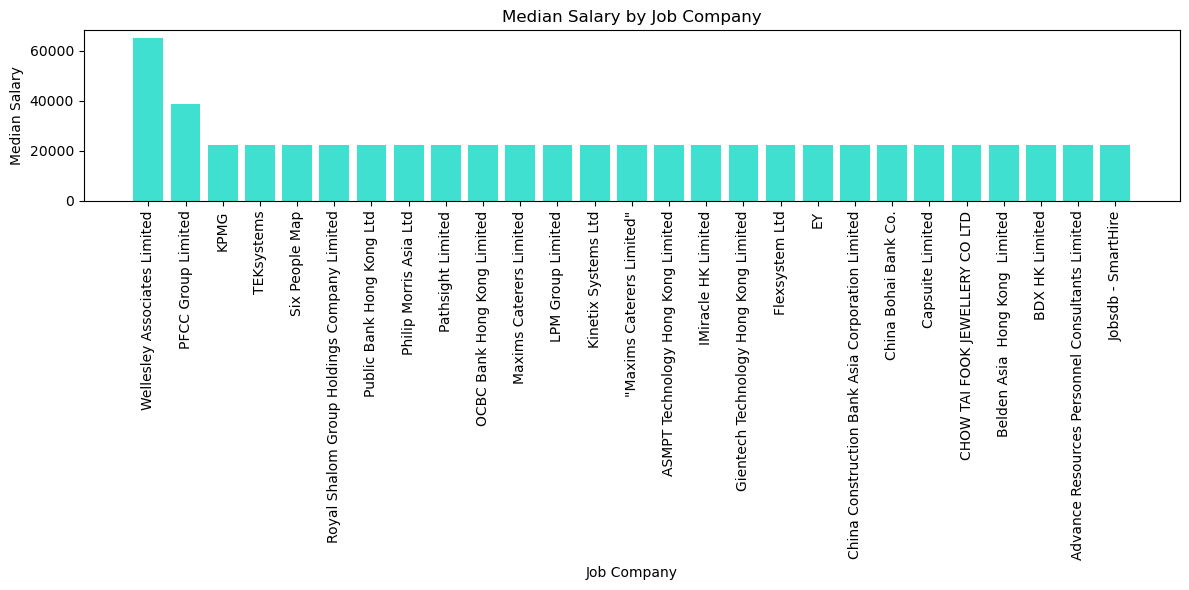

In [20]:
def extract_salary(salary_string):
    pattern = r'\$([\d,]+) – \$([\d,]+)'
    
    matches = re.search(pattern, salary_string)
    
    if matches:
        lower_salary = float(matches.group(1).replace(',', ''))
        upper_salary = float(matches.group(2).replace(',', ''))
        
        median_salary = (lower_salary + upper_salary) / 2
        return median_salary
    else:
        return np.nan

jobs_df['jobSalary'] = jobs_df['jobSalary'].apply(extract_salary)

jobs_df.dropna(subset=['jobSalary'], inplace=True)

company_salary = jobs_df.groupby('jobCompany')['jobSalary'].median().reset_index()

company_salary = company_salary.sort_values(by='jobSalary', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(company_salary['jobCompany'], company_salary['jobSalary'], color='turquoise')
plt.xlabel('Job Company')
plt.ylabel('Median Salary')
plt.title('Median Salary by Job Company')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()



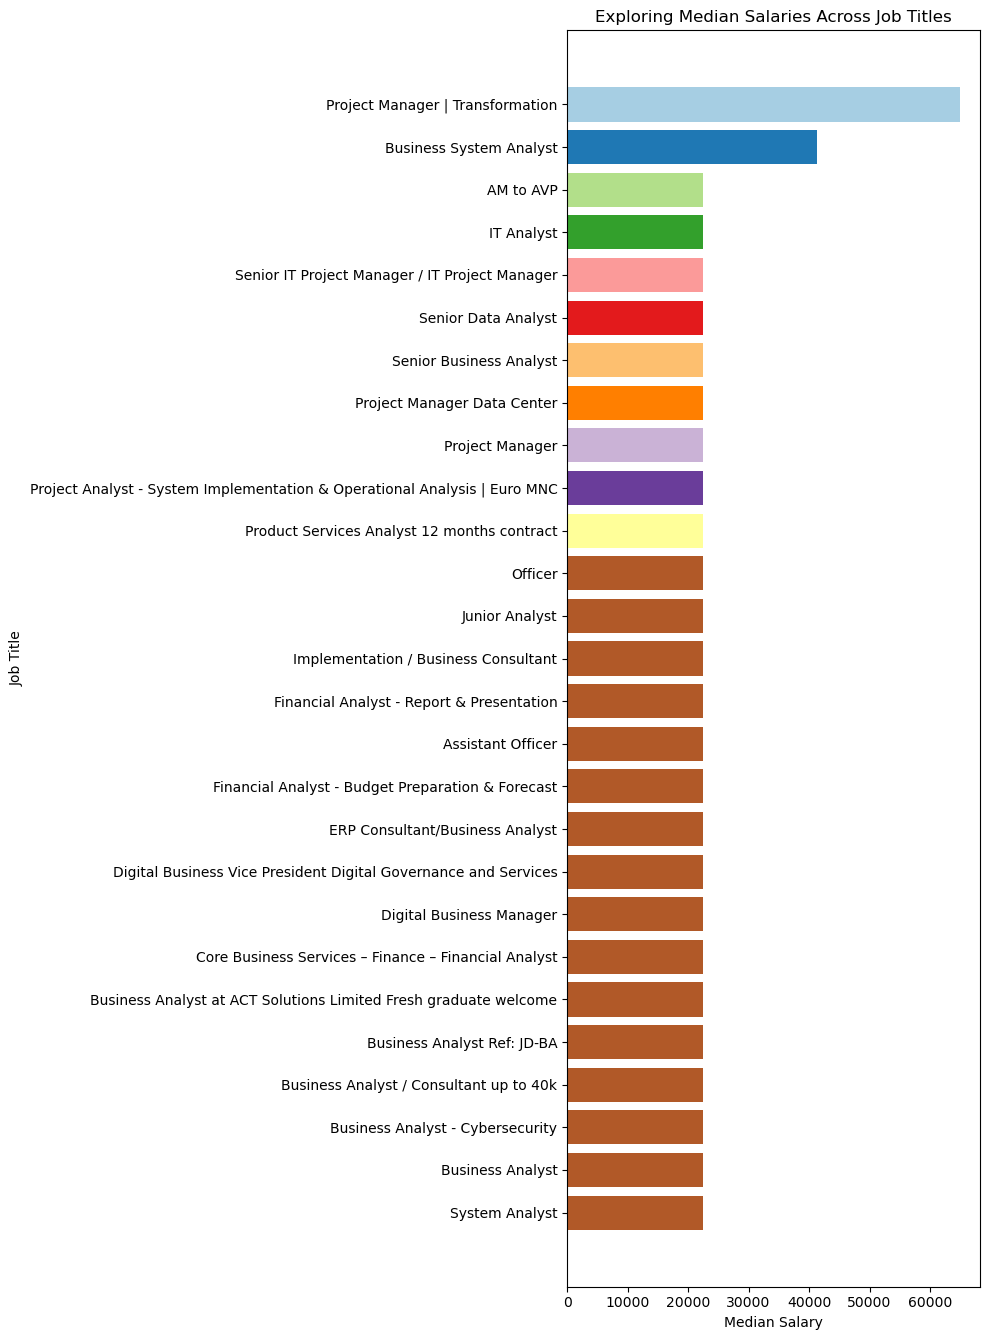

In [21]:
title_salary = jobs_df.groupby('jobTitle')['jobSalary'].median().reset_index()

title_salary = title_salary.sort_values(by='jobSalary', ascending=False)

plt.figure(figsize=(10, len(title_salary) / 2))  
bars = plt.barh(title_salary['jobTitle'], title_salary['jobSalary'], color=plt.cm.Paired(range(len(title_salary))))
plt.xlabel('Median Salary')
plt.ylabel('Job Title')
plt.title('Exploring Median Salaries Across Job Titles')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

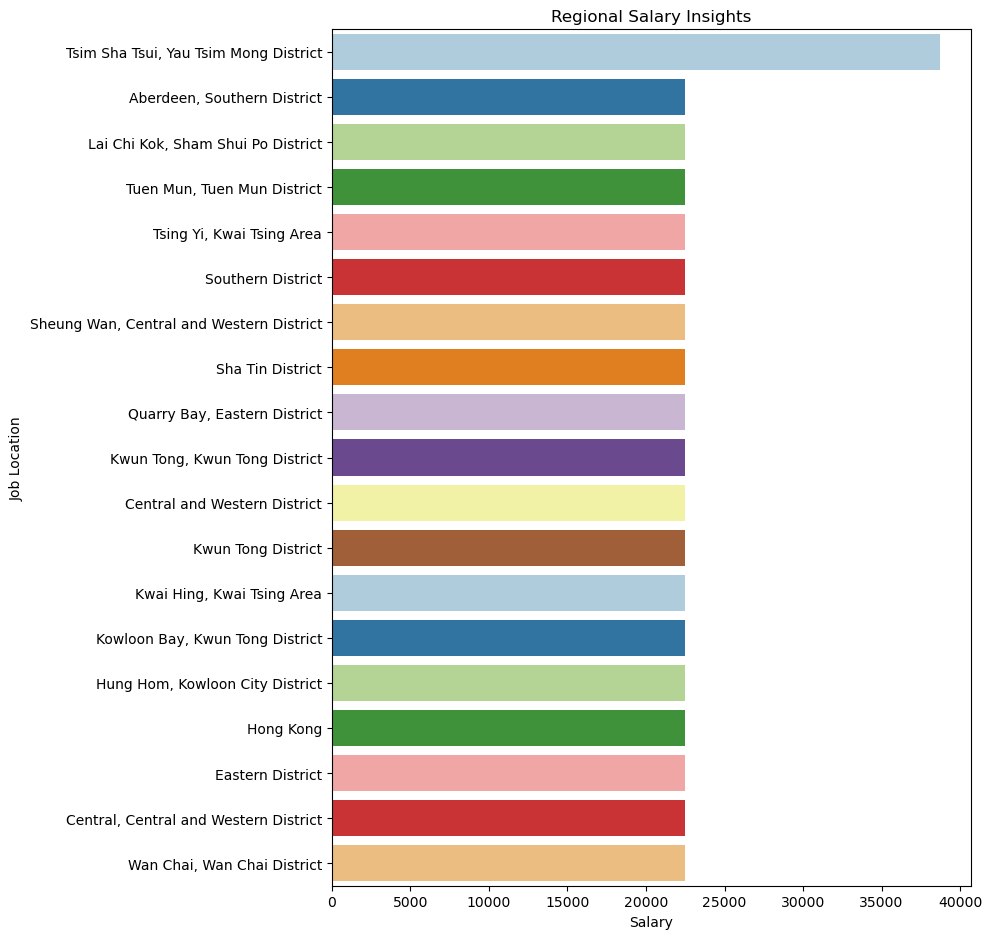

In [22]:
import seaborn as sns
loc_salary = jobs_df.groupby('jobLocation')['jobSalary'].median().reset_index()

loc_salary = loc_salary.sort_values(by='jobSalary', ascending=False)

plt.figure(figsize=(10, len(loc_salary) / 2))

sns.barplot(x='jobSalary', y='jobLocation', data=loc_salary, palette='Paired')

plt.xlabel('Salary')
plt.ylabel('Job Location')
plt.title('Regional Salary Insights')
plt.tight_layout()  

plt.show()



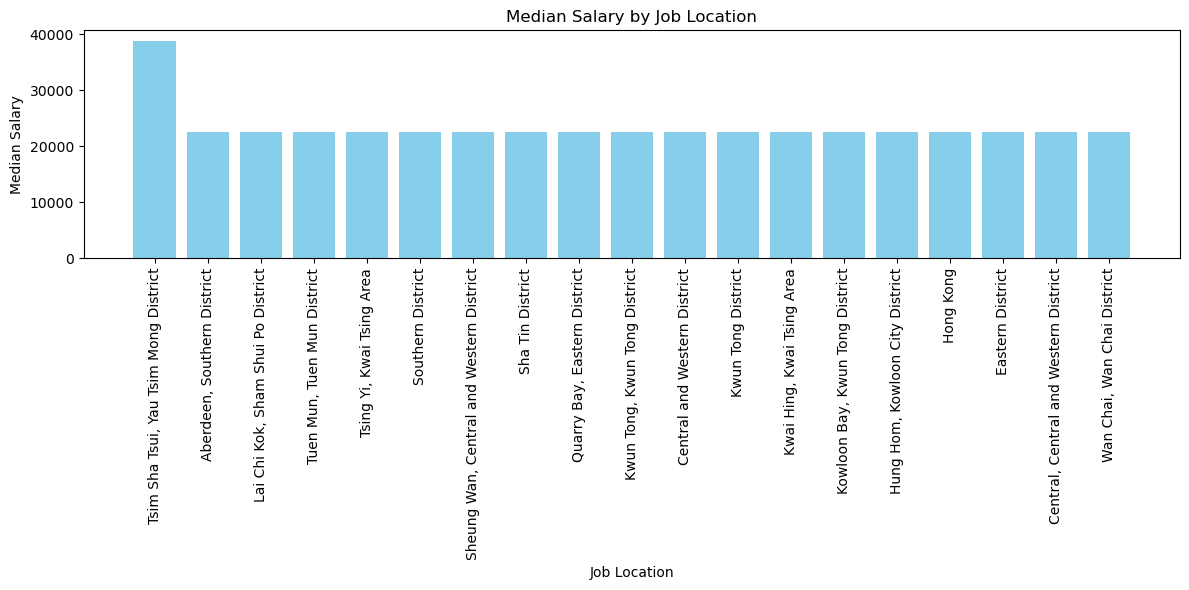

In [23]:
location_salary = jobs_df.groupby('jobLocation')['jobSalary'].median().reset_index()

location_salary = location_salary.sort_values(by='jobSalary', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(location_salary['jobLocation'], location_salary['jobSalary'], color='skyblue')
plt.xlabel('Job Location')
plt.ylabel('Median Salary')
plt.title('Median Salary by Job Location')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

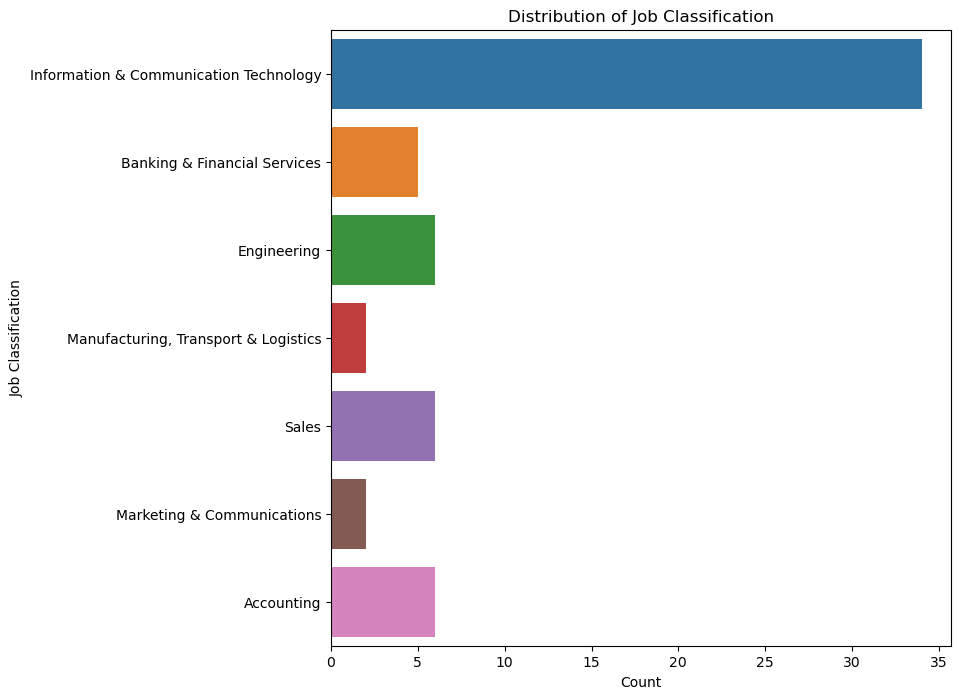

In [24]:
plt.figure(figsize=(8, 8))  
sns.countplot(y='jobClassification', data=jobs_df)  
plt.xlabel('Count') 
plt.ylabel('Job Classification')
plt.title('Distribution of Job Classification')
plt.show()


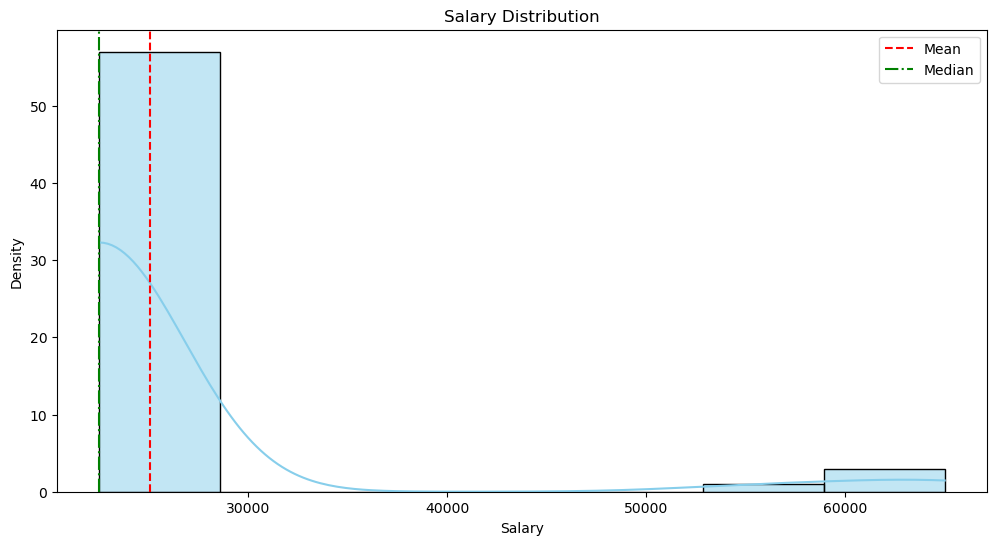

25040.983606557376


In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(jobs_df['jobSalary'], kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.title('Salary Distribution')

mean_salary = np.mean(jobs_df['jobSalary'])
median_salary = np.median(jobs_df['jobSalary'])

plt.axvline(mean_salary, color='red', linestyle='--', label='Mean')
plt.axvline(median_salary, color='green', linestyle='-.', label='Median')

plt.legend()

plt.show()
print(mean_salary)


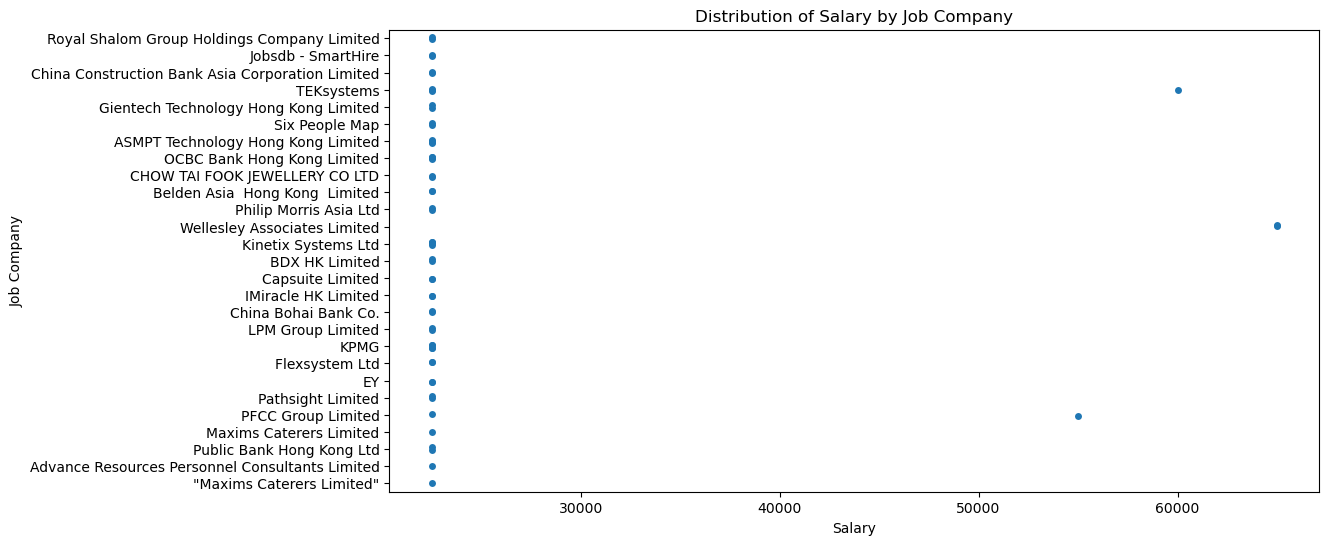

In [26]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='jobSalary', y='jobCompany', data=jobs_df, jitter=True)
plt.xlabel('Salary')
plt.ylabel('Job Company')
plt.title('Distribution of Salary by Job Company')
plt.show()


In [27]:
jobs_df.head()

,jobTitle,jobCompany,jobLocation,jobSalary,jobSubClassification,jobClassification
0,IT Analyst,Royal Shalom Group Holdings Company Limited,Sha Tin District,22500.0,Business/Systems Analysts,Information & Communication Technology
1,Business Analyst at ACT Solutions Limited Fres...,Jobsdb - SmartHire,Southern District,22500.0,Engineering - Software,Information & Communication Technology
2,AM to AVP,China Construction Bank Asia Corporation Limited,"Kowloon Bay, Kwun Tong District",22500.0,Banking - Retail/Branch,Banking & Financial Services
3,Business System Analyst,TEKsystems,Central and Western District,60000.0,Business/Systems Analysts,Information & Communication Technology
4,Senior Business Analyst,Gientech Technology Hong Kong Limited,"Wan Chai, Wan Chai District",22500.0,Business/Systems Analysts,Information & Communication Technology


### Step 5: Prediction of salaries

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer



categorical_columns = ['jobTitle', 'jobCompany','jobLocation','jobSubClassification','jobClassification']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

X = jobs_df.drop('jobSalary', axis=1)  
y = jobs_df['jobSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 108230391.08661996


In [29]:
from sklearn.metrics import mean_absolute_error

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 2951.0624189296805
